# <a name="C2">Import des librairies

In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import seaborn as sns
import datetime as dt
import scipy.stats as st
import re
import time
from datetime import date
from datetime import datetime
pd.options.display.float_format = "{:.2f}".format
warnings.simplefilter("ignore")
import statsmodels.api as sm
from scipy import stats
from scipy.stats import f
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind

# <a name="C2">Import des fichiers et nettoyage des données

## <span style='color:green'> I - Fichier customers   </span>

### _- Importation du fichier_
       

In [2]:
df_customers=pd.read_csv('customers.csv')
df_customers.head()

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943


### _- Vérification des informations du data frame_

In [3]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8623 entries, 0 to 8622
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  8623 non-null   object
 1   sex        8623 non-null   object
 2   birth      8623 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 202.2+ KB


Il y a 8 623 lignes et 3 colonnes.

### _- Vérification des statistiques des colonnes_

In [4]:
df_customers.describe(include='all')  

,client_id,sex,birth
count,8623,8623,8623.00
unique,8623,2,NaN
top,c_4410,f,NaN
freq,1,4491,NaN
mean,NaN,NaN,1978.28
std,NaN,NaN,16.92
min,NaN,NaN,1929.00
25%,NaN,NaN,1966.00
50%,NaN,NaN,1979.00
75%,NaN,NaN,1992.00


### _- Détection des valeurs manquantes_

In [5]:
print(df_customers.isnull().sum())

client_id    0
sex          0
birth        0
dtype: int64


Il n'y a pas de valeurs manquantes.

### _- Détection des doublons_

In [6]:
df_customers.loc[df_customers['client_id'].duplicated(keep=False),:]

,client_id,sex,birth


Il n'y a pas de doublons.

### _- Ajout de 2 colonnes pour faciliter les analyses futures_

In [7]:
# Ajout d'une colonne 'age'
current_year = datetime.now().strftime('%Y')
df_customers['age'] = int(current_year) - df_customers['birth']
df_customers.head()

,client_id,sex,birth,age
0,c_4410,f,1967,56
1,c_7839,f,1975,48
2,c_1699,f,1984,39
3,c_5961,f,1962,61
4,c_5320,m,1943,80


In [8]:
# Utilisation de la fonction describe pour observer la colonne âge
df_customers['age'].describe()

count   8623.00
mean      44.72
std       16.92
min       19.00
25%       31.00
50%       44.00
75%       57.00
max       94.00
Name: age, dtype: float64

In [9]:
# Utilisation de la fonction qcut pour diviser la colonne âge en 5 tranches d'âge
pd.qcut(df_customers['age'], q=5)

0       (48.0, 60.0]
1       (39.0, 48.0]
2       (28.0, 39.0]
3       (60.0, 94.0]
4       (60.0, 94.0]
            ...     
8618    (60.0, 94.0]
8619    (48.0, 60.0]
8620    (48.0, 60.0]
8621    (48.0, 60.0]
8622    (39.0, 48.0]
Name: age, Length: 8623, dtype: category
Categories (5, interval[float64, right]): [(18.999, 28.0] < (28.0, 39.0] < (39.0, 48.0] < (48.0, 60.0] < (60.0, 94.0]]

In [10]:
# Ajout d'une colonne 'tranche d'âge'
df_customers['age_range'] = pd.cut(df_customers['age'],bins=[18,30,40,50,60,100],labels=["18 à 30 ans","30 à 40 ans","40 à 50 ans","50 à 60 ans",
                                                                                          "60 ans et plus"])
df_customers

,client_id,sex,birth,age,age_range
0,c_4410,f,1967,56,50 à 60 ans
1,c_7839,f,1975,48,40 à 50 ans
2,c_1699,f,1984,39,30 à 40 ans
3,c_5961,f,1962,61,60 ans et plus
4,c_5320,m,1943,80,60 ans et plus
...,...,...,...,...,...
8618,c_7920,m,1956,67,60 ans et plus
8619,c_7403,f,1970,53,50 à 60 ans
8620,c_5119,m,1974,49,40 à 50 ans
8621,c_5643,f,1968,55,50 à 60 ans


### _- Détection des valeurs d'un format différent dans la colonne client_id._

In [11]:
# Utilisation de la fonction REGEX, identification des lignes qui ne commencent pas par c suivi d'un tiret et finissant par un
#chiffre
client_id_different = df_customers.loc[~df_customers['client_id'].str.contains(r'^c_\d+$')]
client_id_different

,client_id,sex,birth,age,age_range
2735,ct_0,f,2001,22,18 à 30 ans
8494,ct_1,m,2001,22,18 à 30 ans


Il y a 2 références clients identifiées dans le fichier customers qui correspondent à des tests.

## <span style='color:green'> II - Fichier products </span>

### _- Importation du fichier_

In [12]:
df_products=pd.read_csv('products.csv')
df_products.head()

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0


### _- Vérification des informations du data frame_

In [13]:
df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_prod  3287 non-null   object 
 1   price    3287 non-null   float64
 2   categ    3287 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 77.2+ KB


Il y a 3 287 lignes et 3 colonnes.

### _- Vérification des statistiques des colonnes_

In [14]:
df_products.describe(include='all')  

,id_prod,price,categ
count,3287,3287.00,3287.00
unique,3287,NaN,NaN
top,0_1421,NaN,NaN
freq,1,NaN,NaN
mean,NaN,21.86,0.37
std,NaN,29.85,0.62
min,NaN,-1.00,0.00
25%,NaN,6.99,0.00
50%,NaN,13.06,0.00
75%,NaN,22.99,1.00


Il y a au moins une référence dont le prix est - 1, donc inférieur à 0.


### _- Détection des valeurs manquantes_

In [15]:
print(df_products.isnull().sum())

id_prod    0
price      0
categ      0
dtype: int64


Il n'y a pas de valeurs manquantes.


### _- Détection des doublons_

In [16]:
df_products.loc[df_products['id_prod'].duplicated(keep=False),:]

,id_prod,price,categ


Il n'y a pas de doublons.


### _- Vérifications des valeurs de la colonne price inférieure à 0_

In [17]:
df_products[df_products['price']<=0]

,id_prod,price,categ
731,T_0,-1.00,0


Il y en a une seule.

### _-  Détection des valeurs d'un format différent dans la colonne id_prod._

In [18]:
# Utilisation de la fonction REGEX, identification des lignes qui ne commencent pas par un chiffre suivi d'un underscore et
#finissant par un chiffre
id_prod_different_products = df_products.loc[~df_products['id_prod'].str.contains(r'^\d_\d+$',na=False)]
id_prod_different_products

,id_prod,price,categ
731,T_0,-1.00,0


Il y a une valeur qui ne correspond pas au format de la colonne et qui correspond au prix inférieur à 0.

## <span style='color:green'> III - Fichier transactions </span>

### _- Importation du fichier_

In [19]:
df_transactions=pd.read_csv('transactions.csv')
df_transactions.head()

,id_prod,date,session_id,client_id
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232


### _- Vérification des informations du data frame_

In [20]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679532 entries, 0 to 679531
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id_prod     679532 non-null  object
 1   date        679532 non-null  object
 2   session_id  679532 non-null  object
 3   client_id   679532 non-null  object
dtypes: object(4)
memory usage: 20.7+ MB


Il y a 679 532 lignes et 4 colonnes, on constate qu'il y a un problème au niveau du format de la date.

### _- Vérification des statistiques des colonnes_

In [21]:
df_transactions.describe(include='all')  

,id_prod,date,session_id,client_id
count,679532,679532,679532,679532
unique,3267,679371,342316,8602
top,1_369,test_2021-03-01 02:30:02.237413,s_0,c_1609
freq,2252,13,200,25488


### _- Détection des valeurs manquantes_

In [22]:
print(df_transactions.isnull().sum())

id_prod       0
date          0
session_id    0
client_id     0
dtype: int64


Il n'y a pas de valeurs manquantes.


### _- Détection des doublons_

In [23]:
df_transactions.loc[df_transactions[['id_prod','date','session_id','client_id']].duplicated(keep=False),:]


,id_prod,date,session_id,client_id
3019,T_0,test_2021-03-01 02:30:02.237419,s_0,ct_0
9668,T_0,test_2021-03-01 02:30:02.237437,s_0,ct_1
10728,T_0,test_2021-03-01 02:30:02.237436,s_0,ct_0
15292,T_0,test_2021-03-01 02:30:02.237430,s_0,ct_0
19312,T_0,test_2021-03-01 02:30:02.237449,s_0,ct_0
...,...,...,...,...
653098,T_0,test_2021-03-01 02:30:02.237432,s_0,ct_0
657830,T_0,test_2021-03-01 02:30:02.237417,s_0,ct_0
662081,T_0,test_2021-03-01 02:30:02.237427,s_0,ct_1
671647,T_0,test_2021-03-01 02:30:02.237424,s_0,ct_1


### _- Suppression des doublons_

In [24]:
df_transactions.drop_duplicates(subset=['id_prod','date','session_id','client_id'], inplace=True, ignore_index=True)


### _- Vérification de la colonne id_prod_

In [25]:
# Utilisation de la fonction REGEX, identification des lignes qui ne commencent pas par un chiffre suivi d'un tiret et finissant
#par un chiffre
id_prod_differents_transactions=df_transactions.loc[~df_transactions['id_prod'].str.contains(r'^\d_\d+$',na=False)]
id_prod_differents_transactions

,id_prod,date,session_id,client_id
3019,T_0,test_2021-03-01 02:30:02.237419,s_0,ct_0
5138,T_0,test_2021-03-01 02:30:02.237425,s_0,ct_0
9668,T_0,test_2021-03-01 02:30:02.237437,s_0,ct_1
10728,T_0,test_2021-03-01 02:30:02.237436,s_0,ct_0
15292,T_0,test_2021-03-01 02:30:02.237430,s_0,ct_0
...,...,...,...,...
577222,T_0,test_2021-03-01 02:30:02.237424,s_0,ct_0
592959,T_0,test_2021-03-01 02:30:02.237422,s_0,ct_1
607783,T_0,test_2021-03-01 02:30:02.237412,s_0,ct_0
625936,T_0,test_2021-03-01 02:30:02.237422,s_0,ct_0


In [26]:
# Identification des valeurs uniques des id_prod_differents_transactions
id_prod_differents_transactions['id_prod'].unique()


array(['T_0'], dtype=object)

### _- Vérification si id_prod du fichier df_products correspond au fichier transactions_


In [27]:
liste_id_prod = df_products['id_prod']
liste_id_prod_transactions = df_transactions.loc[~df_transactions['id_prod'].isin(liste_id_prod)]
liste_id_prod_transactions

,id_prod,date,session_id,client_id
2633,0_2245,2022-09-23 07:22:38.636773,s_272266,c_4746
10106,0_2245,2022-07-23 09:24:14.133889,s_242482,c_6713
11727,0_2245,2022-12-03 03:26:35.696673,s_306338,c_5108
15675,0_2245,2021-08-16 11:33:25.481411,s_76493,c_1391
16377,0_2245,2022-07-16 05:53:01.627491,s_239078,c_7954
...,...,...,...,...
669606,0_2245,2021-08-25 09:06:03.504061,s_80395,c_131
670558,0_2245,2022-03-06 19:59:19.462288,s_175311,c_4167
671162,0_2245,2022-05-16 11:35:20.319501,s_209381,c_4453
675554,0_2245,2022-02-11 09:05:43.952857,s_163405,c_1098


Il y a 221 lignes qui ne correspondent pas au fichier products.

In [28]:
# Vérification de ces références ne correspondant pas au fichier df_products
liste_id_prod_transactions['id_prod'].unique()

array(['0_2245'], dtype=object)

Ces 221 lignes correspondent à la référence 0_2245.

# <a name="C2">Création d'un nouveau data frame lapage

### _- Fusion des fichiers customers & transactions_

In [29]:
# Jointure à gauche, 'left' utilise toutes les combinaisons de clés figurant dans le tableau de gauche
df_customers_transactions=pd.merge(df_transactions,df_customers,on=['client_id'],how='left')
df_customers_transactions.head()

,id_prod,date,session_id,client_id,sex,birth,age,age_range
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,f,1986,37,30 à 40 ans
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534,m,1988,35,30 à 40 ans
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714,f,1968,55,50 à 60 ans
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941,m,2000,23,18 à 30 ans
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232,m,1980,43,40 à 50 ans


### _- Vérification des informations du data frame df_customers_transactions_

In [30]:
df_customers_transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679406 entries, 0 to 679405
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   id_prod     679406 non-null  object  
 1   date        679406 non-null  object  
 2   session_id  679406 non-null  object  
 3   client_id   679406 non-null  object  
 4   sex         679406 non-null  object  
 5   birth       679406 non-null  int64   
 6   age         679406 non-null  int64   
 7   age_range   679406 non-null  category
dtypes: category(1), int64(2), object(5)
memory usage: 42.1+ MB


### _- Fusion des fichiers customers,transactions & products_

In [31]:
# Jointure à gauche, 'left' utilise toutes les combinaisons de clés figurant dans le tableau de gauche
df_lapage=pd.merge(df_customers_transactions,df_products,on=['id_prod'],how='left')
df_lapage.head()

,id_prod,date,session_id,client_id,sex,birth,age,age_range,price,categ
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,f,1986,37,30 à 40 ans,4.18,0.00
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534,m,1988,35,30 à 40 ans,15.99,1.00
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714,f,1968,55,50 à 60 ans,7.99,0.00
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941,m,2000,23,18 à 30 ans,69.99,2.00
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232,m,1980,43,40 à 50 ans,4.99,0.00


### _- Vérification des informations du data frame lapage_

In [32]:
df_lapage.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679406 entries, 0 to 679405
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   id_prod     679406 non-null  object  
 1   date        679406 non-null  object  
 2   session_id  679406 non-null  object  
 3   client_id   679406 non-null  object  
 4   sex         679406 non-null  object  
 5   birth       679406 non-null  int64   
 6   age         679406 non-null  int64   
 7   age_range   679406 non-null  category
 8   price       679185 non-null  float64 
 9   categ       679185 non-null  float64 
dtypes: category(1), float64(2), int64(2), object(5)
memory usage: 52.5+ MB


# <a name="C2">Nettoyage des données du data frame lapage

### _- Suppression des lignes test repérées précédemment_

In [33]:
df_lapage.drop(df_lapage.loc[(df_lapage['id_prod']=='T_0')].index, inplace=True)#client_id_different
df_lapage.drop(df_lapage.loc[(df_lapage['client_id']=='ct_0')].index, inplace=True)#id_prod_different_products
df_lapage.drop(df_lapage.loc[(df_lapage['client_id']=='ct_1')].index, inplace=True)#id_prod_transactions
df_lapage.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679332 entries, 0 to 679405
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   id_prod     679332 non-null  object  
 1   date        679332 non-null  object  
 2   session_id  679332 non-null  object  
 3   client_id   679332 non-null  object  
 4   sex         679332 non-null  object  
 5   birth       679332 non-null  int64   
 6   age         679332 non-null  int64   
 7   age_range   679332 non-null  category
 8   price       679111 non-null  float64 
 9   categ       679111 non-null  float64 
dtypes: category(1), float64(2), int64(2), object(5)
memory usage: 52.5+ MB


### _- Détection des valeurs manquantes_

In [34]:
print(df_lapage.isnull().sum())

id_prod         0
date            0
session_id      0
client_id       0
sex             0
birth           0
age             0
age_range       0
price         221
categ         221
dtype: int64


Il y a 221 valeurs manquantes dans les colonnes price et categ.

### _- Observation de la colonne price_

In [35]:
df_lapage.loc[df_lapage['price'].isnull(),:]

,id_prod,date,session_id,client_id,sex,birth,age,age_range,price,categ
2633,0_2245,2022-09-23 07:22:38.636773,s_272266,c_4746,m,1940,83,60 ans et plus,NaN,NaN
10106,0_2245,2022-07-23 09:24:14.133889,s_242482,c_6713,f,1963,60,50 à 60 ans,NaN,NaN
11727,0_2245,2022-12-03 03:26:35.696673,s_306338,c_5108,m,1978,45,40 à 50 ans,NaN,NaN
15675,0_2245,2021-08-16 11:33:25.481411,s_76493,c_1391,m,1991,32,30 à 40 ans,NaN,NaN
16377,0_2245,2022-07-16 05:53:01.627491,s_239078,c_7954,m,1973,50,40 à 50 ans,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
669606,0_2245,2021-08-25 09:06:03.504061,s_80395,c_131,m,1981,42,40 à 50 ans,NaN,NaN
670558,0_2245,2022-03-06 19:59:19.462288,s_175311,c_4167,f,1979,44,40 à 50 ans,NaN,NaN
671162,0_2245,2022-05-16 11:35:20.319501,s_209381,c_4453,m,1981,42,40 à 50 ans,NaN,NaN
675554,0_2245,2022-02-11 09:05:43.952857,s_163405,c_1098,m,1986,37,30 à 40 ans,NaN,NaN


Il y a 221 lignes qui correspondent à la référence identifiée dans le fichier transactions.

### _- Attribution d'une catégorie et d'un prix à la référence 0_2245_


In [36]:
# Vérification de la catégorie 0, pour être sûr que toutes les id_product commencent par 0
categ_0=df_lapage.loc[df_lapage['categ']==0.00]
verif_categ_0 = categ_0.loc[~df_transactions['id_prod'].str.contains(r'^0_\d+$',na=False)]
verif_categ_0

,id_prod,date,session_id,client_id,sex,birth,age,age_range,price,categ


Il n'y a pas dans le fichier de références de la catégorie 0 qui ne commencent pas par 0.

In [37]:
# Statistiques de la catégorie 0
categ_0.describe()

,birth,age,price,categ
count,415459.00,415459.00,415459.00,415459.00
mean,1978.10,44.90,10.64,0.00
std,11.21,11.21,4.93,0.00
min,1929.00,19.00,0.62,0.00
25%,1973.00,37.00,6.29,0.00
50%,1980.00,43.00,9.99,0.00
75%,1986.00,50.00,14.45,0.00
max,2004.00,94.00,40.99,0.00


- Les clients de cette catégorie sont âgés entre 19 et 94 ans, l'âge moyen est de 44.90 ans,
- Les prix de cette catégorie vont de 0.62 à 40.99 euros, le prix moyen est de 10.64 euros.

In [38]:
# Vérification de la catégorie 1, pour être sûr que toutes les id_product commencent par 0
categ_1=df_lapage.loc[df_lapage['categ']==1.00]
verif_categ_1 = categ_1.loc[~df_transactions['id_prod'].str.contains(r'^1_\d+$',na=False)]
verif_categ_1

,id_prod,date,session_id,client_id,sex,birth,age,age_range,price,categ


Il n'y a pas dans le fichier de références de la catégorie 1 qui ne commencent pas par 1.

In [39]:
# Statistiques de la catégorie 1
categ_1.describe()

,birth,age,price,categ
count,227169.00,227169.00,227169.00,227169.00
mean,1974.35,48.65,20.49,1.00
std,15.50,15.50,7.58,0.00
min,1929.00,19.00,2.00,1.00
25%,1964.00,37.00,15.81,1.00
50%,1975.00,48.00,19.08,1.00
75%,1986.00,59.00,24.98,1.00
max,2004.00,94.00,80.99,1.00


- Les clients de cette catégorie sont âgés entre 19 et 94 ans, l'âge moyen est de 48.65 ans,
- Les prix de cette catégorie vont de 2 à 80.99 euros, le prix moyen est de 20.49 euros.

In [40]:
# Vérification de la catégorie 2, pour être sûr que toutes les id_product commencent par 0
categ_2=df_lapage.loc[df_lapage['categ']==2.00]
verif_categ_2 = categ_2.loc[~df_transactions['id_prod'].str.contains(r'^2_\d+$',na=False)]
verif_categ_2

,id_prod,date,session_id,client_id,sex,birth,age,age_range,price,categ


Il n'y a pas dans le fichier de référence de la catégorie 2 qui ne commencent pas par 2.

In [41]:
# Statistiques de la catégorie 2
categ_2.describe()

,birth,age,price,categ
count,36483.00,36483.00,36483.00,36483.00
mean,1996.05,26.95,76.21,2.00
std,9.80,9.80,39.75,0.00
min,1929.00,19.00,30.99,2.00
25%,1994.00,21.00,53.99,2.00
50%,1999.00,24.00,62.83,2.00
75%,2002.00,29.00,73.72,2.00
max,2004.00,94.00,300.00,2.00


- Les clients de cette catégorie sont âgés entre 19 et 94 ans, l'âge moyen est de 26.95 ans,
- Les prix de cette catégorie vont de 30.99 à 300 euros, le prix moyen est de 76.21 euros.

In [42]:
# Attribution de la catégorie 0 à la référence 0_2245
df_lapage['categ']=np.where(df_lapage['id_prod']=='0_2245',0,df_lapage['categ'])

In [43]:
# Calcul de la moyenne de la catégorie 0
moyenne=round(df_lapage.loc[df_lapage['categ']==0,'price'].mean(),2)
print (moyenne)

10.64


In [44]:
# Remplacement des prix manquant par la moyenne
df_lapage['price']=df_lapage['price'].fillna(moyenne)

### _- Ajout d'une nouvelle colonne date et modification du type_

In [45]:
df_lapage['date_2']=df_lapage['date']
df_lapage['date_2'] = pd.to_datetime(df_lapage['date_2'], yearfirst= True)
df_lapage

,id_prod,date,session_id,client_id,sex,birth,age,age_range,price,categ,date_2
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,f,1986,37,30 à 40 ans,4.18,0.00,2022-05-20 13:21:29.043970
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534,m,1988,35,30 à 40 ans,15.99,1.00,2022-02-02 07:55:19.149409
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714,f,1968,55,50 à 60 ans,7.99,0.00,2022-06-18 15:44:33.155329
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941,m,2000,23,18 à 30 ans,69.99,2.00,2021-06-24 04:19:29.835891
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232,m,1980,43,40 à 50 ans,4.99,0.00,2023-01-11 08:22:08.194479
...,...,...,...,...,...,...,...,...,...,...,...
679401,0_1551,2022-01-15 13:05:06.246925,s_150195,c_8489,f,1951,72,60 ans et plus,12.99,0.00,2022-01-15 13:05:06.246925
679402,1_639,2022-03-19 16:03:23.429229,s_181434,c_4370,f,1977,46,40 à 50 ans,10.99,1.00,2022-03-19 16:03:23.429229
679403,0_1425,2022-12-20 04:33:37.584749,s_314704,c_304,f,1988,35,30 à 40 ans,12.99,0.00,2022-12-20 04:33:37.584749
679404,0_1994,2021-07-16 20:36:35.350579,s_63204,c_2227,m,1986,37,30 à 40 ans,4.98,0.00,2021-07-16 20:36:35.350579


# <a name="C2">Création d'un data frame Ventes

In [46]:
df_ventes= df_lapage 
df_ventes=df_lapage.drop(["date"], axis=1)
df_ventes = df_ventes.rename(columns={'categ':'catégorie',"date_2":'date'})
df_ventes

,id_prod,session_id,client_id,sex,birth,age,age_range,price,catégorie,date
0,0_1518,s_211425,c_103,f,1986,37,30 à 40 ans,4.18,0.00,2022-05-20 13:21:29.043970
1,1_251,s_158752,c_8534,m,1988,35,30 à 40 ans,15.99,1.00,2022-02-02 07:55:19.149409
2,0_1277,s_225667,c_6714,f,1968,55,50 à 60 ans,7.99,0.00,2022-06-18 15:44:33.155329
3,2_209,s_52962,c_6941,m,2000,23,18 à 30 ans,69.99,2.00,2021-06-24 04:19:29.835891
4,0_1509,s_325227,c_4232,m,1980,43,40 à 50 ans,4.99,0.00,2023-01-11 08:22:08.194479
...,...,...,...,...,...,...,...,...,...,...
679401,0_1551,s_150195,c_8489,f,1951,72,60 ans et plus,12.99,0.00,2022-01-15 13:05:06.246925
679402,1_639,s_181434,c_4370,f,1977,46,40 à 50 ans,10.99,1.00,2022-03-19 16:03:23.429229
679403,0_1425,s_314704,c_304,f,1988,35,30 à 40 ans,12.99,0.00,2022-12-20 04:33:37.584749
679404,0_1994,s_63204,c_2227,m,1986,37,30 à 40 ans,4.98,0.00,2021-07-16 20:36:35.350579


### _- Ajout de 4 nouvelles colonnes (year,month et day) pour analyse future_

In [47]:
df_ventes['year'] = df_ventes['date'].dt.year
df_ventes['month'] = df_ventes['date'].dt.month
df_ventes['day'] = df_ventes['date'].dt.day
df_ventes['month-year'] = df_ventes['date'].dt.strftime('%Y-%m')
df_ventes.head()

,id_prod,session_id,client_id,sex,birth,age,age_range,price,catégorie,date,year,month,day,month-year
0,0_1518,s_211425,c_103,f,1986,37,30 à 40 ans,4.18,0.00,2022-05-20 13:21:29.043970,2022,5,20,2022-05
1,1_251,s_158752,c_8534,m,1988,35,30 à 40 ans,15.99,1.00,2022-02-02 07:55:19.149409,2022,2,2,2022-02
2,0_1277,s_225667,c_6714,f,1968,55,50 à 60 ans,7.99,0.00,2022-06-18 15:44:33.155329,2022,6,18,2022-06
3,2_209,s_52962,c_6941,m,2000,23,18 à 30 ans,69.99,2.00,2021-06-24 04:19:29.835891,2021,6,24,2021-06
4,0_1509,s_325227,c_4232,m,1980,43,40 à 50 ans,4.99,0.00,2023-01-11 08:22:08.194479,2023,1,11,2023-01


### _- Vérifications des informations_

In [48]:
df_ventes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679332 entries, 0 to 679405
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id_prod     679332 non-null  object        
 1   session_id  679332 non-null  object        
 2   client_id   679332 non-null  object        
 3   sex         679332 non-null  object        
 4   birth       679332 non-null  int64         
 5   age         679332 non-null  int64         
 6   age_range   679332 non-null  category      
 7   price       679332 non-null  float64       
 8   catégorie   679332 non-null  float64       
 9   date        679332 non-null  datetime64[ns]
 10  year        679332 non-null  int64         
 11  month       679332 non-null  int64         
 12  day         679332 non-null  int64         
 13  month-year  679332 non-null  object        
dtypes: category(1), datetime64[ns](1), float64(2), int64(5), object(5)
memory usage: 73.2+ MB


### _- Conversion du type de la colonne categéorie_

In [49]:
# Conversion type colonne categ en integer
df_ventes['catégorie'] = df_ventes['catégorie'].astype('int')


### _- Vérification des statistiques des colonnes_

In [50]:
df_ventes.describe(include='all')

,id_prod,session_id,client_id,sex,birth,age,age_range,price,catégorie,date,year,month,day,month-year
count,679332,679332,679332,679332,679332.00,679332.00,679332,679332.00,679332.00,679332,679332.00,679332.00,679332.00,679332
unique,3266,342315,8600,2,NaN,NaN,5,NaN,NaN,679332,NaN,NaN,NaN,24
top,1_369,s_118668,c_1609,m,NaN,NaN,40 à 50 ans,NaN,NaN,2022-05-20 13:21:29.043970,NaN,NaN,NaN,2021-09
freq,2252,14,25488,340930,NaN,NaN,227765,NaN,NaN,1,NaN,NaN,NaN,33326
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-03-01 00:01:07.843138,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-02-28 23:58:30.792755,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,1977.81,45.19,NaN,17.45,0.44,NaN,2021.67,6.50,15.76,NaN
std,NaN,NaN,NaN,NaN,13.57,13.57,NaN,18.33,0.59,NaN,0.62,3.48,8.80,NaN
min,NaN,NaN,NaN,NaN,1929.00,19.00,NaN,0.62,0.00,NaN,2021.00,1.00,1.00,NaN
25%,NaN,NaN,NaN,NaN,1970.00,36.00,NaN,8.87,0.00,NaN,2021.00,3.00,8.00,NaN


On s'aperçoit que la première date de la colonne date démarre le 01/03/2021 et se termine le 28/02/2023.


### _- Observation de la colonne année pour les année 2021, 2022 et 2023_

In [51]:
# Observation de l'année 2021
annee_2021=df_ventes.loc[df_ventes['year']==2021]
annee_2021['date'].describe()

count                         278335
unique                        278335
top       2021-06-24 04:19:29.835891
freq                               1
first     2021-03-01 00:01:07.843138
last      2021-12-31 23:53:09.887763
Name: date, dtype: object

On constate que les ventes débutent le 1er mars 2021 et se terminent en décembre.


In [52]:
# Observation de l'année 2022
anne_2022=df_ventes.loc[df_ventes['year']==2022]
anne_2022['date'].describe()

count                         346500
unique                        346500
top       2022-05-20 13:21:29.043970
freq                               1
first     2022-01-01 00:04:46.203980
last      2022-12-31 23:56:47.244655
Name: date, dtype: object

In [53]:
# Observation de l'année 2023
anne_2023=df_ventes.loc[df_ventes['year']==2023]
anne_2023['date'].describe()

count                          54497
unique                         54497
top       2023-01-11 08:22:08.194479
freq                               1
first     2023-01-01 00:01:07.843138
last      2023-02-28 23:58:30.792755
Name: date, dtype: object

On constate que les ventes se terminent le 28 février 2023.


# <a name="C2"> I - Analyse des différents indicateurs de vente

## <span style='color:green'> 1 - Différents indicateurs & graphiques représentant le chiffre d'affaires dans le temps </span>

### _- Calcul du chiffre d'affaires total et du nombre total de ventes_

In [54]:
# Calcul du chiffre d'affaires total
ca_total = round(df_ventes['price'].sum(),2)

# Nombre de ventes total
nbre_ventes=df_ventes['id_prod'].count()

print("Le chiffre d'affaires total réalisé en ligne est de", ca_total, "€, pour",nbre_ventes,"ventes.")


Le chiffre d'affaires total réalisé en ligne est de 11856080.12 €, pour 679332 ventes.


### _- Calcul du chiffre d'affaires total et du nombre de ventes par catégorie_

In [55]:
# Data frame du CA et du nombre de ventes par catégorie
ca_ventes_categorie = df_ventes.groupby(['catégorie']).agg({'price':'sum', 'id_prod':'count'})
ca_ventes_categorie.rename(columns={'price':"Chiffre d'Affaires",'id_prod':'Nombre de ventes'},inplace=True)
ca_ventes_categorie

,Chiffre d'Affaires,Nombre de ventes
catégorie,,
0,4422082.41,415680
1,4653722.69,227169
2,2780275.02,36483


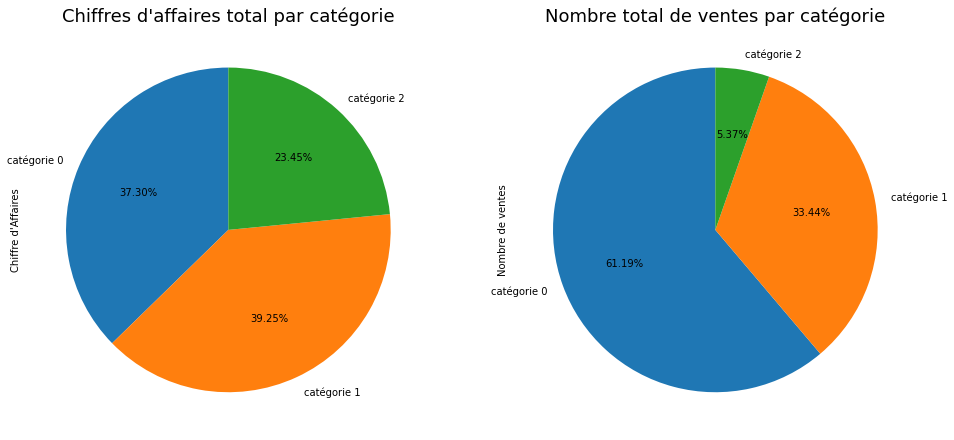

In [56]:
# Graphiques du CA total et du nombre de ventes total en diagrammes circulaires
plt.figure(figsize=(16,10))

plt.subplot(1,2,1)
plt.title("Chiffres d'affaires total par catégorie", fontsize=18)
ca_ventes_categorie["Chiffre d'Affaires"].plot(kind="pie", autopct='%1.2f%%', labels=["catégorie 0","catégorie 1","catégorie 2"],startangle=90)

plt.subplot(1,2,2)
plt.title("Nombre total de ventes par catégorie", fontsize=18)
ca_ventes_categorie['Nombre de ventes'].plot(kind="pie", labels=["catégorie 0","catégorie 1","catégorie 2"],autopct='%1.2f%%', startangle=90)
plt.savefig("CA total et du nombre de ventes total.png")
plt.show()

- La catégorie 0 représente 61,19 % des ventes et 37,30 % du chiffre d'affaires,
- La catégorie 1 représente 33,44 % des ventes et 39,25 % du chiffre d'affaires,
- La catégorie 2 représente 5,37 % des ventes et 23,45 % du chiffre d'affaires.



In [57]:
# Statistiques du chiffre d'affaires et du nombre de ventes
ca_ventes_categorie.describe()

,Chiffre d'Affaires,Nombre de ventes
count,3.00,3.00
mean,3952026.71,226444.00
std,1021354.89,189599.54
min,2780275.02,36483.00
25%,3601178.71,131826.00
50%,4422082.41,227169.00
75%,4537902.55,321424.50
max,4653722.69,415680.00


- La moyenne du chiffre d'affaires entre 2021 à 2023 est de 3 952 026.71 euros,
- La moyenne du nombre de ventes entre 2021 à 2023 est de 226 444.

### _- Calcul du chiffre d'affaires et du nombre de ventes par catégorie d'âge_

In [58]:
# Data frame du CA et du nombre de ventes par catégorie d'âge
ca_ventes_age = df_ventes.groupby(['age_range']).agg({'price':'sum', 'id_prod':'count'})
ca_ventes_age.rename(columns={'id_prod':"Nombre de ventes", 'price':"Chiffres d'affaires en euros"}, inplace=True)
ca_ventes_age

,Chiffres d'affaires en euros,Nombre de ventes
age_range,,
18 à 30 ans,3064862.02,74041
30 à 40 ans,2552700.04,181444
40 à 50 ans,3005621.46,227765
50 à 60 ans,1722166.11,105921
60 ans et plus,1510730.49,90161


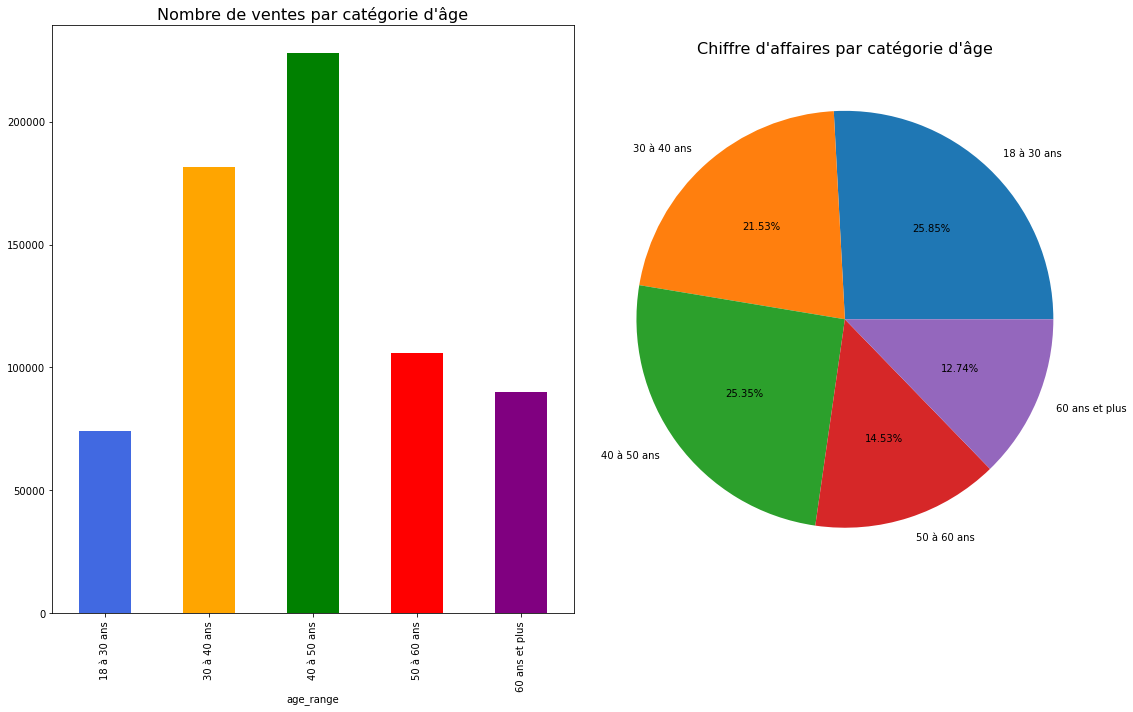

In [59]:
# Graphique en diagramme circulaire pour représenter le chiffre d'affaires et diagramme à barres pour représenter le nombre de ventes

plt.figure( figsize=(16,10) )

plt.subplot(1,2,1)
plt.title("Nombre de ventes par catégorie d'âge", fontsize=16)
ca_ventes_age["Nombre de ventes"].plot(kind="bar",color=['royalblue','orange','green','red','purple'])

plt.subplot(1,2,2)
plt.title("Chiffre d'affaires par catégorie d'âge", fontsize=16)
ca_ventes_age["Chiffres d'affaires en euros"].plot(kind="pie", autopct='%1.2f%%')
plt.ylabel("")

plt.tight_layout()
plt.savefig("CA et du nombre de ventes par catégorie d'âge.png")
plt.show()


Nombre de ventes :
- Les catégories d'âge qui achètent le plus de livres en ligne sont les 40 à 50 ans et les 30 à 40 ans,
- Les catégories d'âge qui achètent le moins de livres en ligne sont les 18 à 30 ans et les plus de 60 ans.

Chiffre d'affaires :
- Le chiffre d'affaires réalisé chez les 40 à 50 ans, et les 18 à 30 ans représente quasiment la même part (25 %), soit plus de 51 % des ventes,
- Le chiffre d'affaires réalisé chez les plus de 60 ans est le moins important, il représente moins de 12.74 % des ventes.


In [60]:
# Statistiques du chiffre d'affaire et du nombre de ventes par tranche d'âge
ca_ventes_age.describe()

,Chiffres d'affaires en euros,Nombre de ventes
count,5.00,5.00
mean,2371216.02,135866.40
std,720807.29,65823.17
min,1510730.49,74041.00
25%,1722166.11,90161.00
50%,2552700.04,105921.00
75%,3005621.46,181444.00
max,3064862.02,227765.00


- La moyenne du chiffre d'affaires réalisé par tranche d'âge est de 2 371 216.02 euros,
- La moyenne du nombre de ventes réalisé par tranche d'âge est de 135 866.40.

In [61]:
ca_id_prod=df_ventes.groupby('id_prod').agg({'price':'sum', 'id_prod':'count'})
ca_id_prod.rename(columns={'id_prod':"Nombre de ventes", 'price':"Chiffres d'affaires en euros"}, inplace=True)
ca_id_prod.describe()

,Chiffres d'affaires en euros,Nombre de ventes
count,3266.00,3266.00
mean,3630.15,208.00
std,7370.83,331.31
min,0.99,1.00
25%,233.83,17.00
50%,797.22,57.00
75%,3406.20,239.00
max,94893.50,2252.00


- La moyenne du chiffre d'affaires réalisée par id_prod est de 3363.46 euros,
- La moyenne du nombre de ventes réalisée par id_prod est de 193.90.

### _- Calcul du chiffre d'affaires et du nombre de ventes par année_

In [62]:
# Data frame du chiffre d'affaires et du nombre de ventes par année
ca_ventes_annee = df_ventes.groupby(['year']).agg({'price':'sum', 'id_prod':'count'})
ca_ventes_annee.rename(columns={"price":"Chiffre d'affaires","id_prod":"Nombre de ventes"},inplace=True)
ca_ventes_annee

,Chiffre d'affaires,Nombre de ventes
year,,
2021,4771752.24,278335
2022,6109958.61,346500
2023,974369.27,54497


### _- Représentation graphique du chiffre d'affaires et du nombre de ventes par année_

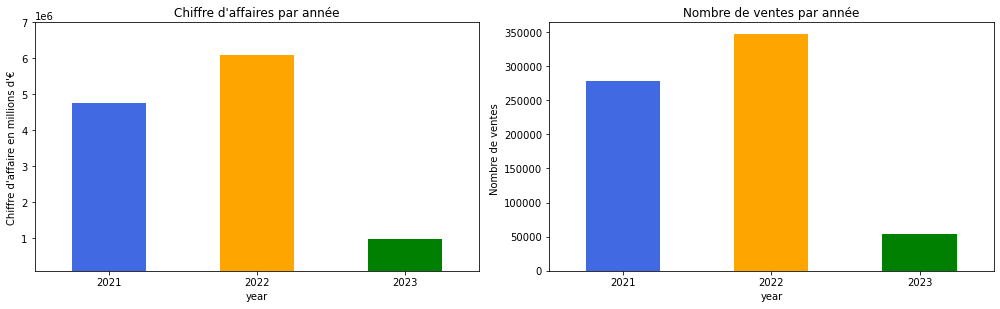

In [63]:
# Graphique : diagramme en barres

plt.figure( figsize=(14,8))

plt.subplot(2,2,1)
ca_ventes_annee["Chiffre d'affaires"].plot(kind="bar",color=['royalblue','orange','green'])
plt.title("Chiffre d'affaires par année")
plt.ylim(100000, 7000000)
plt.ylabel("Chiffre d'affaire en millions d'€")
plt.xticks(rotation=0)

plt.subplot(2,2,2)
ca_ventes_annee["Nombre de ventes"].plot(kind="bar",color=['royalblue','orange','green'])
plt.title("Nombre de ventes par année")
plt.ylabel("Nombre de ventes ")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("Chiffre d'affaires et nombre de ventes par année.png")
plt.show()


L'année 2022 est l'année qui a le plus important chiffre d'affaires ainsi que le plus grand nombre de ventes de livres en ligne.
N'oublions pas que l'année 2021 a débuté en mars et que l'année 2023 s'est arrêtée en février.

### _- Représentation graphique du chiffre d'affaires et du nombre de ventes par mois_

In [64]:
# Décomposition en moyenne mobile
# La moyenne mobile est un type de moyenne statistique utilisée pour analyser des séries ordonnées de données, le plus souvent
# des séries temporelles, en supprimant les fluctuations transitoires de façon à en souligner les tendances à plus long terme. 
# Cette moyenne est dite mobile parce qu'elle est recalculée de façon continue, en utilisant à chaque calcul un sous-ensemble 
# d'éléments dans lequel un nouvel élément remplace le plus ancien ou s'ajoute au sous-ensemble.
# C'est une moyenne qui au lieu d'être calculée sur l'ensemble des n valeurs d'un échantillonnage, est calculée tour à tour sur
# chaque sous-ensemble de N valeurs consécutives (N ≤ n). Le sous-ensemble utilisé pour calculer chaque moyenne, parfois appelé 
#« fenêtre », « glisse » sur l'ensemble des données.
# le calcul suivant montre les moyennes mobiles simples sur 3 valeurs.
ca_mensuel = df_ventes.groupby(['month-year'])['price'].sum()
MovingAverage = ca_mensuel.rolling(3, min_periods=2, center=True).mean()
print(MovingAverage)

month-year
2021-03   479397.32
2021-04   483941.07
2021-05   484483.30
2021-06   486689.86
2021-07   483140.52
2021-08   490875.62
2021-09   436874.04
2021-10   448171.90
2021-11   454379.70
2021-12   522552.69
2022-01   529024.16
2022-02   525551.43
2022-03   514803.34
2022-04   508674.77
2022-05   502180.45
2022-06   508101.41
2022-07   504517.93
2022-08   503891.16
2022-09   502928.95
2022-10   499672.15
2022-11   505029.83
2022-12   508226.78
2023-01   494884.20
2023-02   487184.63
Name: price, dtype: float64


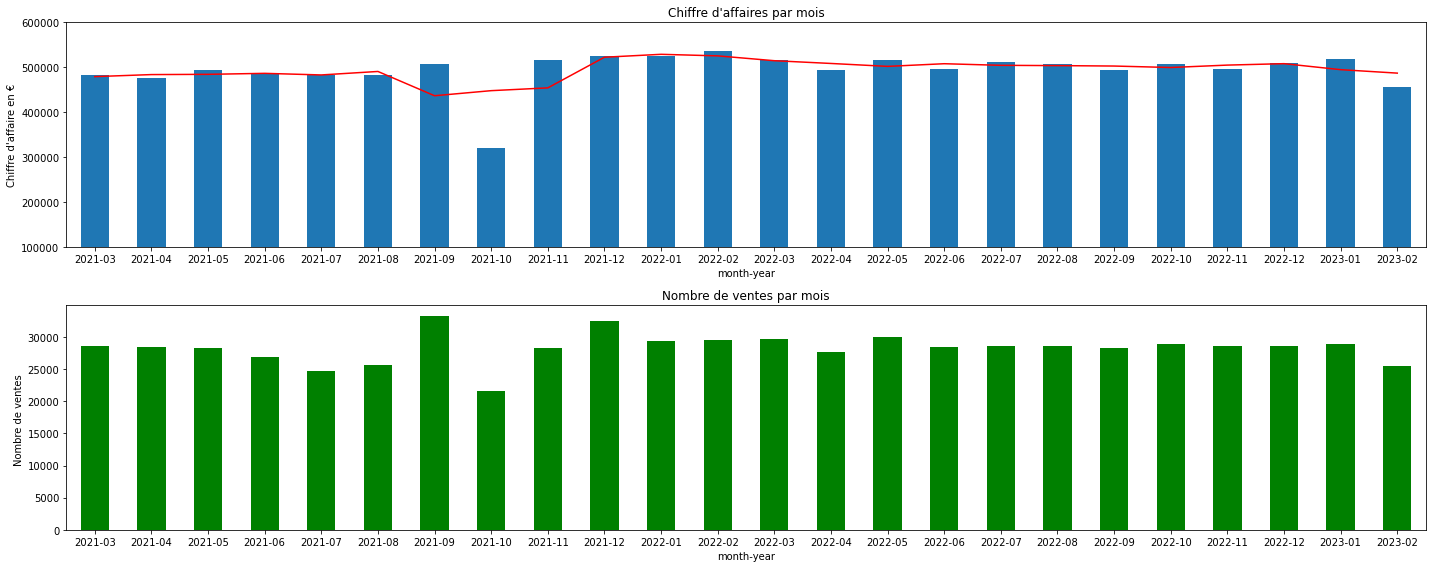

In [65]:
# Graphiques représentant le CA par mois avec la moyenne mobile et le nombre de ventes par mois
plt.figure( figsize=(20,8))

ca_ventes_mois = df_ventes.groupby(['month-year']).agg({'price':'sum', 'session_id':'count'})
ca_ventes_mois.rename(columns={"price":"CA","session_id":"Nombre de ventes"},inplace=True)

plt.subplot(2,1,1)
ca_ventes_mois["CA"].plot(kind="bar")
plt.title("Chiffre d'affaires par mois")
plt.ylim(100000, 600000)
plt.ylabel("Chiffre d'affaire en €")
plt.xticks(rotation=45)
MovingAverage.plot(c='red')


plt.subplot(2,1,2)
ca_ventes_mois["Nombre de ventes"].plot(kind="bar", color='green')
plt.title("Nombre de ventes par mois")
plt.ylabel("Nombre de ventes ")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("Calcul du chiffre d'affaires pour le mois d'octobre 2021.png")
plt.show()

On constate qu'il y a une chute du chiffre d'affaires et du nombre de ventes en octobre 2021 comme observé précédemment.


### _- Représentation graphique du chiffre d'affaires par jour_

In [66]:
# Data frame du chiffre d'affaires par jour
ca_ventes_jour = df_ventes.groupby(df_ventes['date'].dt.date).sum()['price']
ca_ventes_jour

date
2021-03-01   16575.86
2021-03-02   15497.09
2021-03-03   15198.69
2021-03-04   15196.07
2021-03-05   17471.37
               ...   
2023-02-24   15207.89
2023-02-25   15761.25
2023-02-26   16304.72
2023-02-27   19170.81
2023-02-28   18105.15
Name: price, Length: 730, dtype: float64

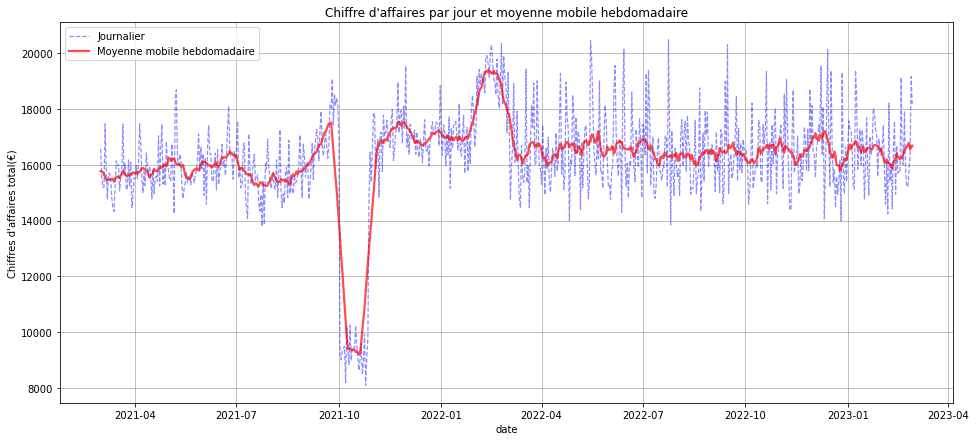

In [67]:
# Utilisation de la fonction .dt.date pour n'extraire que la date

# Décomposition en moyenne mobile
# La moyenne mobile est un type de moyenne statistique utilisée pour analyser des séries ordonnées de données, le plus souvent
# des séries temporelles, en supprimant les fluctuations transitoires de façon à en souligner les tendances à plus long terme. 
# Cette moyenne est dite mobile parce qu'elle est recalculée de façon continue, en utilisant à chaque calcul un sous-ensemble 
# d'éléments dans lequel un nouvel élément remplace le plus ancien ou s'ajoute au sous-ensemble.
# C'est une moyenne qui au lieu d'être calculée sur l'ensemble des n valeurs d'un échantillonnage, est calculée tour à tour sur
# chaque sous-ensemble de N valeurs consécutives (N ≤ n). Le sous-ensemble utilisé pour calculer chaque moyenne, parfois appelé 
#« fenêtre », « glisse » sur l'ensemble des données.
# le calcul suivant montre les moyennes mobiles simples sur 3 valeurs.
Moyenne_mobile_semaine = ca_ventes_jour.rolling(15,min_periods=8, center=True).mean()

plt.figure(figsize=(16,7))
ca_ventes_jour.plot(label="Journalier", lw=1.2, style='--', alpha=0.45, ms=4,color='blue')
Moyenne_mobile_semaine.plot(label="Moyenne mobile hebdomadaire", lw=2.2, color='red', alpha=0.7)

plt.legend()
plt.grid()
plt.ylabel("Chiffres d'affaires total(€)")
plt.savefig("Chiffre d'affaires par jour.png")
plt.title("Chiffre d'affaires par jour et moyenne mobile hebdomadaire");


On observe une baisse du chiffre d'affaire en octobre 2021, continuons nos analyses.

### _- Observation du mois d'octobre 2021_

In [68]:
# Création d'un nouveau data frame
df_octobre_2021 = df_ventes.loc[(df_ventes['month-year'] == '2021-10'), ['day', 'price','catégorie']]
df_octobre_2021 = df_octobre_2021.groupby(['day','catégorie']).agg({'price':['sum','count']}).reset_index()
df_octobre_2021.columns = ['day', 'catégorie', 'ca', 'nombre']
df_octobre_2021 = pd.pivot_table(df_octobre_2021, columns=["catégorie"], index=["day"]).reset_index()
df_octobre_2021.columns = ['day', "catégorie 0", "catégorie 1", "catégorie 2", 'Nbre_ventes_0', 'Nbre_ventes_1', 'Nbre_ventes_2']
df_octobre_2021


,day,catégorie 0,catégorie 1,catégorie 2,Nbre_ventes_0,Nbre_ventes_1,Nbre_ventes_2
0,1,6950.50,7003.79,3104.05,663.00,344.00,38.00
1,2,7141.01,NaN,2041.12,661.00,NaN,28.00
2,3,6786.57,NaN,2206.48,648.00,NaN,31.00
3,4,6554.88,NaN,2746.08,603.00,NaN,38.00
4,5,6357.91,NaN,3032.55,594.00,NaN,38.00
5,6,7546.58,NaN,1944.11,702.00,NaN,26.00
6,7,6404.01,NaN,1787.07,597.00,NaN,26.00
7,8,7069.53,NaN,3137.82,669.00,NaN,44.00
8,9,6808.69,NaN,2616.67,640.00,NaN,35.00
9,10,6490.98,NaN,2334.67,600.00,NaN,29.00


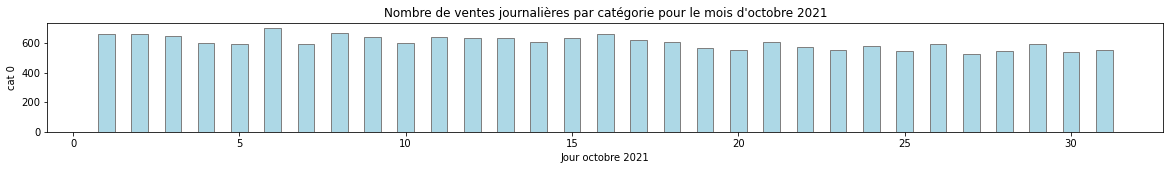

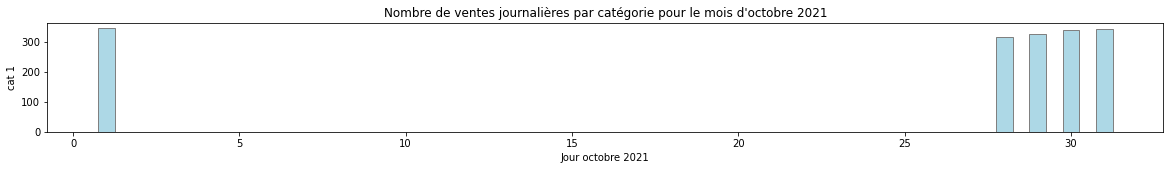

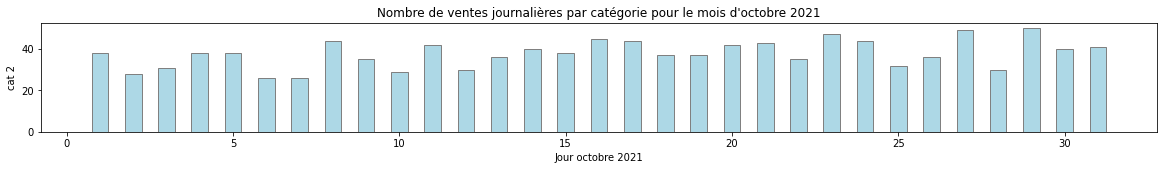

In [69]:
# Création d'un graphique à partir du nouveau dataframe df_octobre_2021

for i, cat in enumerate([0,1,2]):
    plt.figure(figsize=(44,2))
    plt.subplot(1,2,2)
    plt.bar(df_octobre_2021['day'], df_octobre_2021[f'Nbre_ventes_{cat}'], width=0.5, color='lightblue',edgecolor = "grey", linewidth = 1)
    plt.xlabel('Jour octobre 2021')
    plt.ylabel(f'cat {cat}')
    plt.title("Nombre de ventes journalières par catégorie pour le mois d'octobre 2021")
    plt.show()

Il n'y a pas eu de ventes dans la catégorie 1 entre le 2 et le 27 octobre, il y a peut-être eu un problème lors de l'extraction des données (à vérifier).

## <span style='color:green'>2 - Zoom sur les références</span>

### _- Tops & flops par chiffre d'affaires_

In [70]:
# Tops
ca_top = df_ventes.groupby(['id_prod','catégorie']).agg({'price':'sum'})
ca_top.rename(columns={"price":"Chiffre d'affaires"},inplace=True)
ca_top.sort_values(by=["Chiffre d'affaires"], ascending = False).head(10)

,,Chiffre d'affaires
id_prod,catégorie,
2_159,2,94893.50
2_135,2,69334.95
2_112,2,65407.76
2_102,2,60736.78
2_209,2,56971.86
1_395,1,54356.25
1_369,1,54025.48
2_110,2,53846.25
2_39,2,53060.85


In [71]:
# Flops
ca_flop = df_ventes.groupby(['id_prod','catégorie']).agg({'price':'sum'})
ca_flop.rename(columns={"price":"Chiffre d'affaires"},inplace=True)
ca_flop.sort_values(by=["Chiffre d'affaires"], ascending = [True]).head(10)

,,Chiffre d'affaires
id_prod,catégorie,
0_1539,0,0.99
0_1284,0,1.38
0_1653,0,1.98
0_541,0,1.99
0_807,0,1.99
0_1601,0,1.99
0_1728,0,2.27
0_1498,0,2.48
0_898,0,2.54


- Les tops des livres mis en vente en terme de chiffre d'affaires appartiennent à la catégorie 2 et 1,
- Les flops des livres mis en vente en terme de chiffre d'affaires appartiennent à la catégorie 0.

### _- Tops et flops en nombre de ventes_

In [72]:
# Tops
top_ventes = df_ventes.groupby(['id_prod','catégorie']).agg({'id_prod':'count'})
top_ventes.rename(columns={"id_prod":"Nombre de ventes"},inplace=True)
top_ventes.sort_values(by=["Nombre de ventes"], ascending = [False]).head(10)


,,Nombre de ventes
id_prod,catégorie,
1_369,1,2252
1_417,1,2189
1_414,1,2180
1_498,1,2128
1_425,1,2096
1_403,1,1960
1_412,1,1951
1_413,1,1945
1_406,1,1939


In [73]:
# Flops
flop_ventes = df_ventes.groupby(['id_prod','catégorie']).agg({'id_prod':'count'})
flop_ventes.rename(columns={"id_prod":"Nombre de ventes"},inplace=True)
flop_ventes.sort_values(by=["Nombre de ventes"], ascending = [True]).head(10)


,,Nombre de ventes
id_prod,catégorie,
0_549,0,1
0_2201,0,1
2_23,2,1
0_1284,0,1
0_1683,0,1
0_833,0,1
2_98,2,1
0_1633,0,1
0_1601,0,1


- Les tops des livres mis en vente en terme de nombre de ventes appartiennent à la catégorie 1,
- Les flops des livres mis en vente en terme de nombre de ventes appartiennent aux catégories 0 et 2.



### _- Tops & flops par catégorie (en chiffre d'affaires)_

In [74]:
# Tops des ventes par catégorie 
top_ref_categorie= df_ventes.groupby(["catégorie","id_prod"]).agg({'price':'sum'}).reset_index()
top_ref_categorie.rename(columns={"price":"Chiffre d'affaires"},inplace=True)
top_ref_categorie.loc[top_ref_categorie.groupby('catégorie')["Chiffre d'affaires"].nlargest(2).index.get_level_values(1)]

,catégorie,id_prod,Chiffre d'affaires
487,0,0_1441,23452.65
465,0,0_1421,23008.49
2620,1,1_395,54356.25
2592,1,1_369,54025.48
3097,2,2_159,94893.50
3071,2,2_135,69334.95


In [75]:
# Flops des ventes par catégorie 
top_ref_categorie= df_ventes.groupby(["catégorie","id_prod"]).agg({'price':'sum'}).reset_index()
top_ref_categorie.rename(columns={"price":"Chiffre d'affaires"},inplace=True)
top_ref_categorie.loc[top_ref_categorie.groupby('catégorie')["Chiffre d'affaires"].nsmallest(2).index.get_level_values(1)]

,catégorie,id_prod,Chiffre d'affaires
595,0,0_1539,0.99
313,0,0_1284,1.38
2649,1,1_420,14.24
2432,1,1_224,19.80
3248,2,2_81,86.99
3176,2,2_23,115.99


### _- Tops & flops par catégorie d'âge (en chiffre d'affaires)_

In [76]:
# Tops des ventes par catégorie d'âge
top_ref_sex= df_ventes.groupby(["id_prod",'age_range']).agg({'price':'sum'}).reset_index()
top_ref_sex.rename(columns={"price":"Chiffre d'affaires"},inplace=True)
top_ref_sex.loc[top_ref_sex.groupby('age_range')["Chiffre d'affaires"].nlargest(2).index.get_level_values(1)]


,id_prod,age_range,Chiffre d'affaires
15355,2_135,18 à 30 ans,57261.70
15230,2_112,18 à 30 ans,56083.10
15486,2_159,30 à 40 ans,21168.55
12961,1_369,30 à 40 ans,10243.73
15487,2_159,40 à 50 ans,24818.30
12962,1_369,40 à 50 ans,12882.63
13103,1_395,50 à 60 ans,14002.17
15488,2_159,50 à 60 ans,13139.10
12964,1_369,60 ans et plus,12882.63
13214,1_414,60 ans et plus,12177.13


In [77]:
# Flops des ventes par catégorie d'âge
top_ref_sex= df_ventes.groupby(["id_prod",'age_range']).agg({'price':'sum'}).reset_index()
top_ref_sex.rename(columns={"price":"Chiffre d'affaires"},inplace=True)
top_ref_sex.loc[top_ref_sex.groupby('age_range')["Chiffre d'affaires"].nsmallest(2).index.get_level_values(1)]


,id_prod,age_range,Chiffre d'affaires
10,0_10,18 à 30 ans,0.00
15,0_100,18 à 30 ans,0.00
16,0_100,30 à 40 ans,0.00
116,0_102,30 à 40 ans,0.00
52,0_1006,40 à 50 ans,0.00
142,0_1024,40 à 50 ans,0.00
18,0_100,50 à 60 ans,0.00
48,0_1005,50 à 60 ans,0.00
19,0_100,60 ans et plus,0.00
49,0_1005,60 ans et plus,0.00


indice de Gini: 0.694


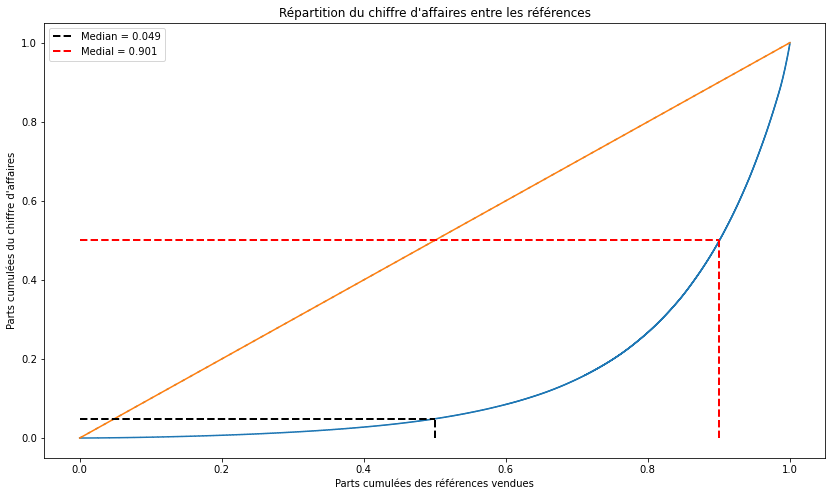

In [78]:
# Courbe de Lorenz: (Repartition du CA par référence)
#La courbe de Lorenz est une représentation graphique de la distribution d'une variable (revenu, patrimoine, etc.) au sein
#d'une population.
#l'état de concentration d'un marché avec la ventilation des parts de marché.
# En résumé, plus la courbe de Lorenz est proche de la première bissectrice, plus la répartition est égalitaire.

# Le coefficient de Gini, ou indice de Gini, est une mesure statistique permettant de rendre compte de la répartition d'une 
#variable  au sein d'un groupe. Autrement dit, il mesure le niveau d'inégalité de la 
#répartition d'une variable dans le groupe.
#Le coefficient de Gini est un nombre variant de 0 à 1, où 0 signifie l'égalité parfaite et 1, qui ne peut être atteint, 
#signifierait une inégalité parfaite (une seule personne dispose de tous les revenus et une infinité d’autres n'ont aucun revenu).
nombre_ventes_ref = df_ventes.groupby(['id_prod'])['id_prod'].count()
lorenz_CA_prod = np.cumsum(np.sort(nombre_ventes_ref)) / nombre_ventes_ref.sum()
lorenz_CA_prod = np.append([0], lorenz_CA_prod)

plt.figure( figsize=(14,8))
plt.plot(np.linspace(0,1,len(lorenz_CA_prod)), lorenz_CA_prod, drawstyle='steps-post'),
plt.plot(np.linspace(0,1,len(lorenz_CA_prod)), np.linspace(0,1,len(lorenz_CA_prod)),color ="grey", dashes=[2,4])
plt.plot([0,1], [0,1]) #tracer la bisséctrice
plt.ylabel("Parts cumulées du chiffre d'affaires")
plt.xlabel("Parts cumulées des références vendues")
plt.title("Répartition du chiffre d'affaires entre les références")
aire_ss_courbe_CA_prod = lorenz_CA_prod[:-1].sum() / len(lorenz_CA_prod)
S_ca_prod = 0.5 - aire_ss_courbe_CA_prod
gini_CA_prod = 2* S_ca_prod

Me = lorenz_CA_prod [int(len(lorenz_CA_prod ) / 2)]
plt.plot([0.5, 0.5], [0, Me], color='black', linestyle='--', linewidth=2, label='Median = %.3f'%Me)
plt.plot([0, 0.5], [Me, Me], color='black', linestyle='--', linewidth=2)

Ml = len(lorenz_CA_prod [lorenz_CA_prod <= 0.5]) / len(lorenz_CA_prod )
plt.plot([0, Ml], [0.5, 0.5], color='red', linestyle='--', linewidth=2, label='Medial = %.3f'%Ml)
plt.plot([Ml, Ml], [0, 0.5], color='red', linestyle='--', linewidth=2)

plt.legend()

print("indice de Gini:",round(gini_CA_prod,3))

# La médiane permet la constitution de deux groupes égaux dans les parts cumulées des âges clients
# La médiale permet la constitution de deux groupes égaux dans les parts cumulées du chiffre d'affaires


- 80 % des références vendues représentent 20 % du chiffres d'affaires,
- 20 % des références vendues représentent 80 % du chiffres d'affaires.

L'indice de gini (qui est de 0.694) confirme cette inégalité.

## <span style='color:green'> 3 - Profils clients</span>

### _- Top clients_

In [79]:
# Création d'un data frame top clients
top_clients = df_ventes.groupby(["client_id"]).agg({"price":"sum", "id_prod":"count"})
top_clients.rename(columns={"price":"Chiffre d'affaires en €","id_prod":"Nombre d'achats"}, inplace=True)
top_clients.sort_values(by=["Chiffre d'affaires en €"], ascending=False).head(10)


,Chiffre d'affaires en €,Nombre d'achats
client_id,,
c_1609,324033.35,25488
c_4958,289760.34,5195
c_6714,153662.76,9187
c_3454,113669.85,6773
c_3263,5276.87,403
c_1570,5271.62,369
c_2899,5214.05,105
c_2140,5208.82,402
c_7319,5155.77,371


4 Clients ont un chiffre d'affaires beaucoup plus important que les autres.

In [80]:
clients_outliers=top_clients.loc[top_clients["Chiffre d'affaires en €"]>50000]
clients_outliers

,Chiffre d'affaires en €,Nombre d'achats
client_id,,
c_1609,324033.35,25488
c_3454,113669.85,6773
c_4958,289760.34,5195
c_6714,153662.76,9187


indice de Gini: 0.447


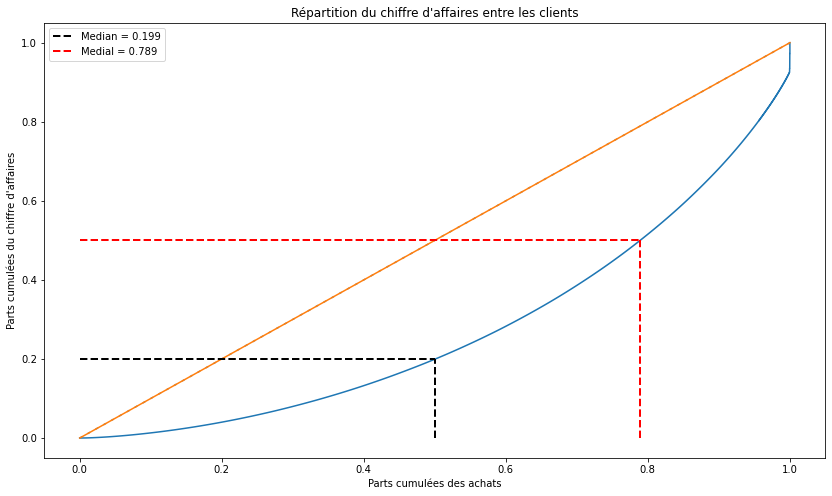

In [81]:
# Répartition du CA par clients (Courbe de Lorenz)

#La courbe de Lorenz est une représentation graphique de la distribution d'une variable (revenu, patrimoine, etc.) au sein
#d'une population.
#l'état de concentration d'un marché avec la ventilation des parts de marché.
# En résumé, plus la courbe de Lorenz est proche de la première bissectrice, plus la répartition est égalitaire.

# Le coefficient de Gini, ou indice de Gini, est une mesure statistique permettant de rendre compte de la répartition d'une 
#variable  au sein d'un groupe. Autrement dit, il mesure le niveau d'inégalité de la 
#répartition d'une variable dans le groupe.
#Le coefficient de Gini est un nombre variant de 0 à 1, où 0 signifie l'égalité parfaite et 1, qui ne peut être atteint, 
#signifierait une inégalité parfaite (une seule personne dispose de tous les revenus et une infinité d’autres n'ont aucun revenu).

best_client = df_ventes.groupby(["client_id"])["price"].sum()
lorenz_CA_client = np.cumsum(np.sort(best_client)) / best_client.sum()
lorenz_CA_client = np.append([0], lorenz_CA_client)

plt.figure( figsize=(14,8))
plt.plot(np.linspace(0,1,len(lorenz_CA_client)), lorenz_CA_client, drawstyle="steps-post")
plt.plot(np.linspace(0,1,len(lorenz_CA_client)), np.linspace(0,1,len(lorenz_CA_client)), color ="grey", dashes=[2,4])
plt.plot([0,1], [0,1]) #tracer la bisséctrice
plt.ylabel("Parts cumulées du chiffre d'affaires")
plt.xlabel("Parts cumulées des achats")
plt.title("Répartition du chiffre d'affaires entre les clients")
aire_ss_courbe_CA_client = lorenz_CA_client[:-1].sum() / len(lorenz_CA_client)
S_ca_client = 0.5 - aire_ss_courbe_CA_client
gini_CA_client = 2*S_ca_client


Me = lorenz_CA_client [int(len(lorenz_CA_client ) / 2)]
plt.plot([0.5, 0.5], [0, Me], color='black', linestyle='--', linewidth=2, label='Median = %.3f'%Me)
plt.plot([0, 0.5], [Me, Me], color='black', linestyle='--', linewidth=2)

Ml = len(lorenz_CA_client [lorenz_CA_client <= 0.5]) / len(lorenz_CA_client )
plt.plot([0, Ml], [0.5, 0.5], color='red', linestyle='--', linewidth=2, label='Medial = %.3f'%Ml)
plt.plot([Ml, Ml], [0, 0.5], color='red', linestyle='--', linewidth=2)

plt.legend()

print("indice de Gini:",round(gini_CA_client,3))


La courbe se rapproche de la bissectrice vers la fin en ligne droite cela signifie que la répartition est inégalitaire :
- 65 % des achats cumulés représentent 36 % du chiffres d'affaires,
- 35 % des achats cumulés représentent 64 % du chiffres d'affaires.

L'indice de gini (qui est de 0.447) confirme cette inégalité.

Les 4 clients identifiés précedemment ont un fort impact sur notre analyse, nous décidons donc de les écarter pour la suite.

### _- Suppression des 4 clients_

In [82]:
# df_ventes=df_ventes.loc[~df_ventes.client_id.isin(clients_outliers)]
df_ventes.drop(df_ventes.loc[(df_ventes['client_id']=='c_1609')].index, inplace=True)
df_ventes.drop(df_ventes.loc[(df_ventes['client_id']=='c_4958')].index, inplace=True)
df_ventes.drop(df_ventes.loc[(df_ventes['client_id']=='c_6714')].index, inplace=True)
df_ventes.drop(df_ventes.loc[(df_ventes['client_id']=='c_3454')].index, inplace=True)

In [83]:
# Nombre d'achats et montant moyen par client:
nbre_achats_moyen = df_ventes.groupby(["client_id"])["session_id"].count().mean()
montant_achats_moyen = df_ventes.groupby(["client_id"])["price"].sum().mean()

print("Le nombre moyen d'achat par client depuis l'ouverture de notre site est", round(nbre_achats_moyen,2))
print("Le montant moyen d'achat par client depuis l'ouverture de notre site est", round(montant_achats_moyen,2))

Le nombre moyen d'achat par client depuis l'ouverture de notre site est 73.6
Le montant moyen d'achat par client depuis l'ouverture de notre site est 1276.75


In [84]:
# Nombre de sessions
df_ventes["session_id"].nunique()

319274

In [85]:
# Nombre moyen d'achats par client
round(df_ventes.groupby(["session_id","client_id"])["id_prod"].count().mean(),2)

1.98

### _- Statistitiques de la colonne price_

In [86]:
# Utilisation de la fonction describe
df_ventes['price'].describe()

count   632689.00
mean        17.35
std         18.09
min          0.62
25%          8.82
50%         13.99
75%         18.99
max        300.00
Name: price, dtype: float64

- Le prix moyen d'un livre en ligne est de 17.45 euros,
- Le livre le moins cher est à 0.62 euros,
- Le livre le plus cher est à 300 euros.

### _- Prix moyen d'un livre pour chaque catégorie_

In [87]:
prix_moyen_categorie=df_ventes.groupby('catégorie').agg({'price':'mean'})
prix_moyen_categorie


,price
catégorie,
0,10.64
1,20.48
2,76.23


- Le prix moyen d'un livre appartenant à la catégorie 0 est de 10.64 euros,
- Le prix moyen d'un livre appartenant à la catégorie 1 est de 20.49 euros,
- Le prix moyen d'un livre appartenant à la catégorie 2 est de 76.21 euros.

# <a name="C2"> II -  Analyse plus ciblée sur les clients

In [88]:
# Data frame du CA et du nombre de ventes par sexe
ca_ventes_sex = df_ventes.groupby(['sex']).agg({'price':'sum', 'id_prod':'count'})
ca_ventes_sex.rename(columns={'id_prod':"Nombre de ventes", 'price':"Chiffres d'affaires en euros"}, inplace=True)
ca_ventes_sex

,Chiffres d'affaires en euros,Nombre de ventes
sex,,
f,5707265.25,329215
m,5267688.57,303474


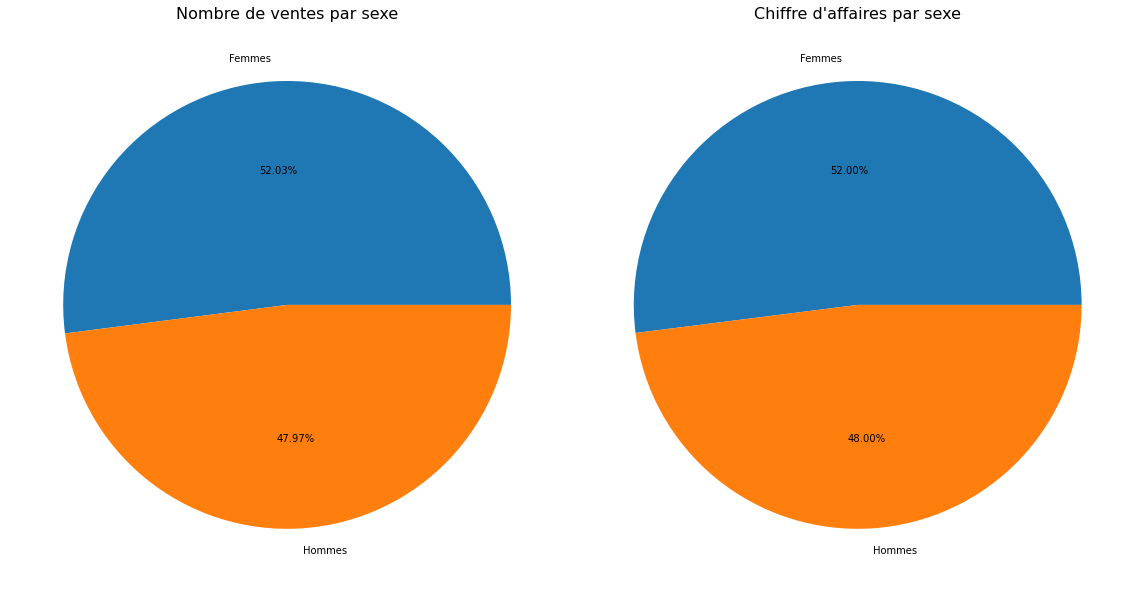

In [89]:
# Graphique en diagramme circulaire et à barres pour représenter le chiffre d'affaires et le nombre de  ventes par sexe

plt.figure( figsize=(16,10) )

plt.subplot(1,2,1)
plt.title("Nombre de ventes par sexe", fontsize=16)
ca_ventes_sex["Nombre de ventes"].plot(kind="pie",autopct='%1.2f%%',labels=["Femmes","Hommes"])
plt.ylabel("")

plt.subplot(1,2,2)
plt.title("Chiffre d'affaires par sexe", fontsize=16)
ca_ventes_sex["Chiffres d'affaires en euros"].plot(kind="pie", autopct='%1.2f%%',labels=["Femmes","Hommes"])
plt.ylabel("")

plt.tight_layout()
plt.savefig("CA et du nombre de ventes par sexe.png")
plt.show()

- Les femmes achètent un peu plus en ligne, 2 %,
- Le nombre de ventes et le chiffre d'affaires représentent quasiment la même part dans les 2 catégories.

### _- 1 - Lien entre le genre des clients et les catégorie des livres achetés_

In [90]:
# Table de contingence pour Chi²

X = "sex", 
Y = "catégorie"
categorie_sex = df_ventes[["sex","catégorie"]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total")
categorie_sex 

catégorie,0,1,2,Total
sex,,,,
f,200904,111331,16980,329215
m,186589,101017,15868,303474
Total,387493,212348,32848,632689


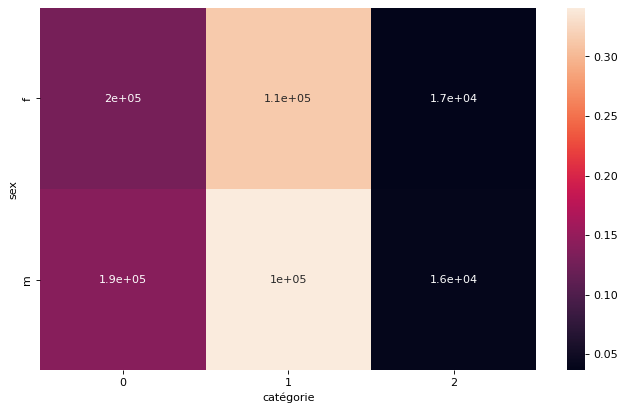

In [91]:
#heatmap  table de contingence entre sex et catégorie

# Chaque carré montre la corrélation entre les variables sur chaque axe. La corrélation varie de -1 à +1. Des valeurs plus 
# proches de zéro signifient qu'il n'y a pas de tendance linéaire entre les deux variables. Plus la corrélation est proche de la,
# valeur maximale plus elles sont corrélées positivement ; c'est-à-dire qu'à mesure que l'un augmente, l'autre augmente et plus
# la valeur est proche du max, plus cette relation est forte. Une corrélation plus proche du minimum est similaire, mais au lieu 
# d'augmenter les deux, une variable diminuera à mesure que l'autre augmentera.

fig = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
plt.clf()

tx = categorie_sex.loc[:,["Total"]]
ty = categorie_sex.loc[["Total"],:]
n = len(df_ventes)
indep = tx.dot(ty) / n

c = categorie_sex.fillna(0) # On remplace les valeurs nulles par 0
measure = (c-indep)**2/indep
xi_n = measure.sum().sum()
table = measure/xi_n
sns.heatmap(table.iloc[:-1,:-1],annot=c.iloc[:-1,:-1])
plt.show()


In [92]:
# Analyser deux variables qualitatives avec le Chi-2
print("--"*127,"\n")
print("Test d'indépendance entre les variables sexe et catégorie (test Chi-2)")
print("\t Hypothèse nulle H0 : \t Le choix d'une catégorie de livre ne dépend pas du du client.")
print("\t Autre hypothèse H1 : \t Le choix d'une catégorie de livre dépend du client.")
print('')

#Calcul du Chi² et de la p-value
X2, Y2 = "sex", "catégorie"
conti2 = df_ventes[[X2, Y2]].pivot_table(index=X2, columns=Y2, aggfunc=len).fillna(0).copy()
st_chi2, st_p, st_dof, st_exp = st.chi2_contingency(conti2)
print("Le Chi² est de : ",st_chi2,"\n")
print("La p-value est de :",st_p,"\n")

if st_p < 0.05 :
    print("L'hypothèse nulle est rejetée \t ==> H1: Le choix d'une catégorie de livre dépend du sexe du client.")
else:
    print("L'hypothèse nulle ne peut être rejetée H0 (Le choix d'une catégorie de livre ne dépend pas du sexe du client.")

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- 

Test d'indépendance entre les variables sexe et catégorie (test Chi-2)
	 Hypothèse nulle H0 : 	 Le choix d'une catégorie de livre ne dépend pas du du client.
	 Autre hypothèse H1 : 	 Le choix d'une catégorie de livre dépend du client.

Le Chi² est de :  20.200173796862927 

La p-value est de : 4.1075985631484716e-05 

L'hypothèse nulle est rejetée 	 ==> H1: Le choix d'une catégorie de livre dépend du sexe du client.


### _- Lien entre l'âge des clients et le montant total des achats_

Corrélation de Spearman: SpearmanrResult(correlation=-0.8736842105263158, pvalue=7.352708223159905e-25)


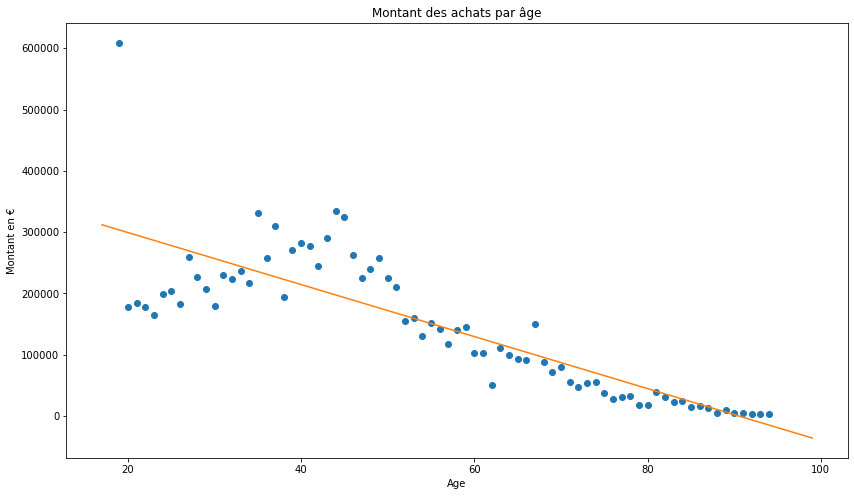

In [93]:
# Corrélation  entre l'age et le montant des achats
tot_achats_age = df_ventes
tot_achats_age = df_ventes.groupby("age",as_index=False)["price"].sum()

# Le coefficient de corrélation varie entre -1 et +1
# La corrélation de Spearman mesure le lien entre deux variables. Cette corrélation n'utilise pas les valeurs des données mais
#leur RANG. Le coefficient de corrélation varie entre -1 et +1, 0 reflétant une relation nulle entre les deux variables, une 
# valeur négative (corrélation négative) signifiant que lorsqu'une des variable augmente, l'autre diminue ; tandis qu'une 
# valeur positive (corrélation positive) indique que les deux variables varient ensemble dans le même sens.

# Graphique scatterplot
X = tot_achats_age[["age"]]
Y = tot_achats_age["price"]
X = X.copy()
X['intercept'] = 1.
result = sm.OLS(Y, X).fit() # OLS = Ordinary Least Square (Moindres Carrés Ordinaire)
a,b = result.params['age'],result.params['intercept']
plt.figure( figsize=(14,8))
plt.xlabel("Age")
plt.ylabel("Montant en €")
plt.plot(tot_achats_age.age,tot_achats_age.price, "o")
plt.plot(np.arange(17,100),[a*x+b for x in np.arange(17,100)])
plt.title("Montant des achats par âge")

print("Corrélation de Spearman:", st.spearmanr(tot_achats_age["age"], tot_achats_age['price']))


La corrélation de spearman est de -0.87, il se rapproche de -1, cela signifie une très forte association négative  entre les rangs.

On peut émettre l'hypothèse que plus les consommateurs sont âgés, plus le montant total de leur achat est faible.


In [94]:
# Repartition des achats par tranches d'âges
repartition_achats_age_range = df_ventes.groupby(["age_range"])["price"].sum()
print("Montant total des achats par tranches d'age:\n", repartition_achats_age_range)

# Nombre d'achats par tranches d'âges
nbr_achats_age_range = df_ventes.groupby(["age_range"])["id_prod"].count()
print("Nombre total d'achats par tranches d'age:\n",nbr_achats_age_range)

# Montant moyen des achats par tranches d'âge
moy_achats_age_range = df_ventes.groupby(["age_range"])["price"].mean()
print("Montant moyen des achats par tranches d'age:\n", moy_achats_age_range)

Montant total des achats par tranches d'age:
 age_range
18 à 30 ans      2775101.68
30 à 40 ans      2552700.04
40 à 50 ans      2681588.11
50 à 60 ans      1454833.50
60 ans et plus   1510730.49
Name: price, dtype: float64
Nombre total d'achats par tranches d'age:
 age_range
18 à 30 ans        68846
30 à 40 ans       181444
40 à 50 ans       202277
50 à 60 ans        89961
60 ans et plus     90161
Name: id_prod, dtype: int64
Montant moyen des achats par tranches d'age:
 age_range
18 à 30 ans      40.31
30 à 40 ans      14.07
40 à 50 ans      13.26
50 à 60 ans      16.17
60 ans et plus   16.76
Name: price, dtype: float64


### _- Lien entre l'âge des clients et la fréquence d'achat_

In [95]:
# Corrélation entre l'âge et la fréquence des achats
frequence_achats = df_ventes
frequence_achats["Chiffres d'affaires"] = frequence_achats['price'].sum()
frequence_achats =frequence_achats.groupby(['age','client_id'], as_index=False)['session_id'].count()
frequence_achats["Nombre de clients"]= frequence_achats['client_id'].count()
frequence_achats = frequence_achats.groupby(['age',"Nombre de clients"], as_index=False)['session_id'].sum()
frequence_achats['frequence_achat'] = frequence_achats['session_id']/frequence_achats["Nombre de clients"]
frequence_achats

,age,Nombre de clients,session_id,frequence_achat
0,19,8596,15149,1.76
1,20,8596,4371,0.51
2,21,8596,4587,0.53
3,22,8596,4252,0.49
4,23,8596,4415,0.51
...,...,...,...,...
71,90,8596,327,0.04
72,91,8596,311,0.04
73,92,8596,170,0.02
74,93,8596,226,0.03


Corrélation de Spearman: SpearmanrResult(correlation=-0.6738482570061518, pvalue=2.5391854434818517e-11)


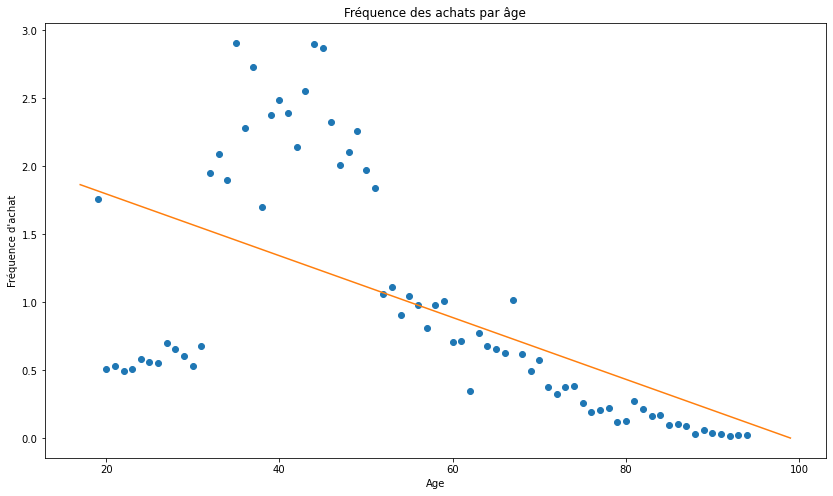

In [96]:
# Graphique scatterplot
# La corrélation de Spearman mesure le lien entre deux variables. Cette corrélation n'utilise pas les valeurs des données mais
#leur RANG. Le coefficient de corrélation varie entre -1 et +1, 0 reflétant une relation nulle entre les deux variables, une 
# valeur négative (corrélation négative) signifiant que lorsqu'une des variable augmente, l'autre diminue ; tandis qu'une 
# valeur positive (corrélation positive) indique que les deux variables varient ensemble dans le même sens.
X = frequence_achats[["age"]]
Y = frequence_achats['frequence_achat']
X = X.copy()
X['intercept'] = 1.
result = sm.OLS(Y, X).fit() # OLS = Ordinary Least Square (Moindres Carrés Ordinaire)
a,b = result.params['age'],result.params['intercept']
plt.figure( figsize=(14,8))
plt.xlabel("Age")
plt.ylabel("Fréquence d'achat")
plt.plot(frequence_achats.age,frequence_achats.frequence_achat, "o")
plt.plot(np.arange(17,100),[a*x+b for x in np.arange(17,100)])
plt.title("Fréquence des achats par âge")

print("Corrélation de Spearman:", st.spearmanr(frequence_achats["age"], frequence_achats['frequence_achat']))

La corrélation de spearman est de -0.67, il se rapproche de -1, cela signifie une très forte association négative entre les rangs.

On peut émettre l'hypothèse que plus les consommateurs sont âgés, moins ils achètent de livres en ligne.

### _- Lien entre l'âge des clients et la taille du panier moyen_

In [97]:
# Corrélation entre l'âge et la taille du panier moyen
# Le panier moyen correspond au montant dépensé par un client 
# Nombre de produits par âge et par session
panier2 = df_ventes.groupby(['age','session_id'])['id_prod'].count().reset_index()

# Pour ensuite avoir la moyenne de ce nombre
panier2 = panier2.groupby('age').mean().reset_index()
panier2

,age,id_prod
0,19,1.76
1,20,1.70
2,21,1.76
3,22,1.75
4,23,1.82
...,...,...
71,90,1.40
72,91,1.51
73,92,1.77
74,93,1.55


Corrélation de Spearman: SpearmanrResult(correlation=-0.631742993848257, pvalue=9.392789651862638e-10)


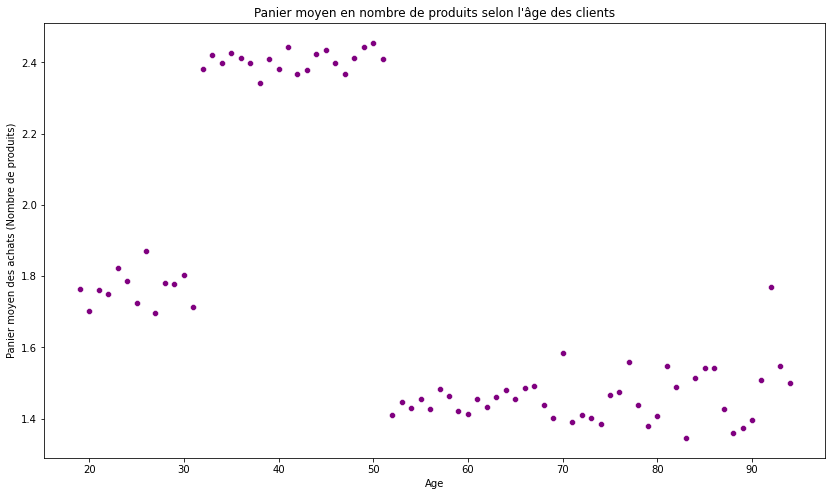

In [98]:
# Graphique scatterplot
# Le coefficient de corrélation varie entre -1 et +1
# La corrélation de Spearman mesure le lien entre deux variables. Cette corrélation n'utilise pas les valeurs des données mais
#leur RANG. Le coefficient de corrélation varie entre -1 et +1, 0 reflétant une relation nulle entre les deux variables, une 
# valeur négative (corrélation négative) signifiant que lorsqu'une des variable augmente, l'autre diminue ; tandis qu'une 
# valeur positive (corrélation positive) indique que les deux variables varient ensemble dans le même sens.

plt.figure( figsize=(14,8))
sns.scatterplot(x=panier2["age"], y=panier2["id_prod"],color='purple')
plt.xlabel('Age')
plt.ylabel("Panier moyen des achats (Nombre de produits)")
plt.title("Panier moyen en nombre de produits selon l'âge des clients")

print("Corrélation de Spearman:", st.spearmanr(panier2['age'], panier2["id_prod"]))
plt.show()


La corrélation est proche de -1 .On peut émettre l'hypothèse que plus les consommateurs sont âgés, moins la taille du panier est importante.

### _- Lien entre l'âge des clients et les catégories de livres achetés_

In [99]:
# Création d'un data frame en fonction de l'âge et des catégories de livres achetés
age_categorie = df_ventes.groupby(['age','catégorie']).agg({"id_prod":"count"}).reset_index()
age_categorie.rename(columns={"id_prod":"Nombre d'achats"}, inplace=True)
age_categorie.columns = ['age', 'catégorie', "Nombre d'achats"]

age_categorie = pd.pivot_table(age_categorie, columns=["catégorie"], index=['age']).reset_index()
age_categorie.columns = ['age', "catégorie 0", "catégorie 1", "catégorie 2"]
age_categorie

,age,catégorie 0,catégorie 1,catégorie 2
0,19,3418,5719,6012
1,20,909,1678,1784
2,21,1019,1723,1845
3,22,974,1550,1728
4,23,1116,1628,1671
...,...,...,...,...
71,90,143,183,1
72,91,132,177,2
73,92,77,91,2
74,93,75,149,2


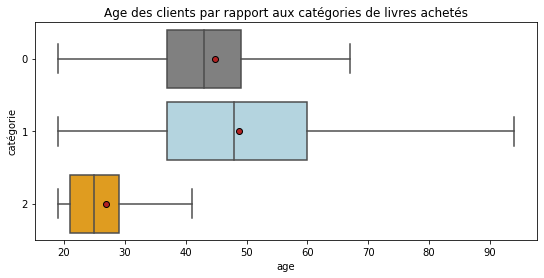

In [100]:
#Graphique en box plot

plt.figure(figsize=(9,4))
palette = ['grey','lightblue','orange']
medianprops = {'color':"black"}
meanprops={'marker':'o', 'markeredgecolor':'black','markerfacecolor':'firebrick'}
sns.boxplot(data=df_ventes, y='catégorie', x='age', orient='h', showfliers=False, showmeans=True, palette=palette,
            meanprops=meanprops)
plt.title("Age des clients par rapport aux catégories de livres achetés")
plt.show()



Les ronds rouges au milieu de chaque boîte à moustaches représentent la moyenne des valeurs :
- 45 ans pour la catégorie 0,
- 49 ans pour la catégorie 1,
- 27 ans pour la catégorie 2.

On voit ici que les âges des clients sont très différents d'une catégorie à l'autre :
- Les âges sont de 19 à 67 ans pour la catégorie 0,
- Les âges sont de 19 à 94 ans pour la catégorie 1,
- Les âges sont de 19 à 41 ans pour la catégorie 2.


In [101]:
# Test de normalité à l'aide d'un test de shapiro
# Sachant que l'hypothèse nulle est que la population est normalement distribuée,
#si la p-value est inférieure à un niveau alpha choisi (par exemple 0.05), alors l'hypothèse nulle est rejetée.
#si la p-value est supérieure au niveau alpha choisi (par exemple 0.05), alors on ne doit pas rejeter l'hypothèse nulle.
# La valeur de la p-value alors obtenue ne présuppose en rien de la nature de la distribution des données.
X = "catégorie"
Y = "age"
categ_disp = df_ventes['catégorie'].unique()
print(stats.shapiro(categ_disp))



ShapiroResult(statistic=1.0, pvalue=0.999998927116394)


La p-valeur est supérieur à 0.05, l'hypothèse nulle ne peut être rejetée. Notre échantillon est distribué normalement.


In [102]:
# ANOVA teste l'homogénéité de la moyenne de la variable quantitative étudiée sur les différentes valeurs de la variable 
#qualitative. Les règles empiriques suivantes sont utilisées pour interpréter les valeurs d'Eta au carré :
# 0.01 : petite taille d'effet
# 0.06 : taille d'effet moyenne
# 0.14 ​​ou supérieur : grande taille d'effet

# Code permettant de calculer 𝜂2
def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT
    
eta_squared(df_ventes[X],df_ventes[Y])

0.1132752589826815

Le η2 est proche de 0.14, on peut en déduire qu'il y a une relation entre l'âge des clients et la catégorie des livres achetés en ligne.


CONCLUSION

Après les tests de corrélation effectués, nous pouvons dire que :

- Le choix d'une catégorie de livre dépend du sexe du client,  
- Il y a un lien entre l'âge des clients et la fréquence d'achat, plus les clients sont âgés et plus le montant total de leur achat est faible,
- Il y a un lien entre l'âge et le panier moyen, plus les clients sont âgés, moins la taille du panier est importante.
- Il y a une relation entre l'âge des clients et la catégorie des livres achetés en ligne.